# Preliminary Working Memory Model

This is the model that our team created during the 2024 Neuromatch Summer School.


(Insert a heck ton of README-style explanation for the preliminary model OR put the info in the main README file for both models.)

## Setup and dependencies

In [54]:
!pip install nilearn --quiet
!pip install graphviz --quiet
!pip install visualkeras --quiet

import os
import re
import tarfile
import requests
import visualkeras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt

from glob import glob
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import BinaryCrossentropy

from tensorflow.keras.metrics import BinaryAccuracy

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.regularizers import l2

## Figure settings

In [55]:
# Figure settings will be inserted.

## Parameters and Data Download
The data used for the preliminary model was shared by Neuromatch in the [Project Booklets](https://compneuro.neuromatch.io/projects/fMRI/README.html#:~:text=5%2D23%2C%202021-,HCP%20task%20datasets,-%23) and most of our data preparation is similar to what they have shared in the ```load_hcp_task_with_behaviour.ipynb``` in the [HCP 2021 + behavior](https://compneuro.neuromatch.io/projects/fMRI/README.html#:~:text=View-,HCP%202021%20%2B%20behavior,-HCP%202021) section.

Our target experiments (```TargetExperiments``` variable below) are Working Memory, Emotion, and Language tasks.

In [56]:
N_SUBJECTS = 100
N_PARCELS = 360 # Data aggregated into ROIs from Glasser parcellation
TR = 0.72  # Time resolution, in seconds
HEMIS = ["Right", "Left"]
RUNS   = ["LR","RL"]
N_RUNS = 2

EXPERIMENTS = {
    "MOTOR"      : {"cond" : ["lf", "rf" ,"lh", "rh", "t", "cue"]},
    "WM"         : {"cond" : ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools",
                              "2bk_body", "2bk_faces", "2bk_places", "2bk_tools"]},
    "SOCIAL"     : {"cond" : ["ment", "rnd"]},
    "GAMBLING"   : {"cond" : ["loss", "win"]},
    "EMOTION"    : {"cond" : ["fear", "neut"]},
    "LANGUAGE"   : {"cond" : ["math", "story"]},
    "RELATIONAL" : {"cond" : ["match", "relation"]}
}

TargetExperiments = ["WM", "EMOTION", "LANGUAGE"]

TargetConditions  = ["0bk_body", "0bk_faces", "0bk_places", "0bk_tools",
                     "2bk_body", "2bk_faces", "2bk_places", "2bk_tools",
                     "fear"    , "neut"     , "math"      , "story"    ]

In [57]:
fname = "hcp_task.tgz"
url = "https://osf.io/2y3fw/download"

if not os.path.isfile(fname):
  try:
    r = requests.get(url)
  except requests.ConnectionError:
    print("Download FAILED: Connection Error!")
  else:
    if r.status_code != requests.codes.ok:
      print("Download FAILED!")
    else:
      with open(fname, "wb") as fid:
        fid.write(r.content)


HCP_DIR = "./hcp_task"

with tarfile.open(fname) as tfile:
  tfile.extractall('.')

C:\Users\User\AppData\Local\Temp\ipykernel_23300\2612373236.py:20: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tfile.extractall('.')


In [58]:
SubjectIDs = np.loadtxt(os.path.join(HCP_DIR, 'subjects_list.txt'), dtype='str')
SubjectIDs = list(SubjectIDs)

### ```regions.npy``` file, parcels, and subnetworks
(Insert doc about what the regions file is)

In [59]:
regions = np.load(f"{HCP_DIR}/regions.npy").T

region_info = dict(
    name=regions[0].tolist(),
    network=regions[1],
    hemi=['Right']*int(N_PARCELS/2) + ['Left']*int(N_PARCELS/2),
)

In [60]:
"""
THIS SECTION OF CODE WILL BE REPLACED BY CODE THAT DIRECTLY EXTRACTS
THE NUMBERS AND CONSTUCTS THE DICTIONARY FROM THE regions.npy FILE.
"""

ventral_attention_parcels    = [121, 134]

orbital_affective_parcels    = [111, 165, 289, 291, 345]

dorsal_attention_parcels     = [26, 139, 140, 206, 207, 320]

limbic_parcels               = [109, 111, 165, 289, 291, 345]

auditory_parcels             = [23, 102, 103, 123, 172, 173, 
                                174, 282, 286, 287, 288, 303, 352, 353, 354]

default_mode_parcels         = [11, 24, 25, 27, 
                                73, 74, 78, 80, 122, 124, 127, 128, 138, 171, 
                                191, 205, 254, 258, 302, 304, 308, 318, 351]

language_parcels             = [10, 45, 49, 94, 
                                95, 115, 126, 135, 136, 142, 145, 225, 229, 
                                274, 275, 295, 296, 306, 315, 316, 322, 325]

frontoparietal_parcels       = [13, 14, 
                                28, 62, 72, 76, 79, 81, 82, 84, 96, 97, 110, 
                                132, 143, 144, 148, 169, 170, 208, 242, 252,
                                256, 259, 260, 262, 264, 276, 277, 290, 298]

somatomotor_parcels          = [7, 8, 35, 38, 39, 40, 41, 46, 
                                50, 51, 52, 53, 54, 55, 99, 100, 101, 167, 
                                187, 188, 215, 218, 219, 220, 221, 226, 230, 
                                231, 232, 233, 234, 235, 279, 280, 281, 347]

cingulo_opercular_parcels    = [9, 36, 37, 42, 43, 44, 56, 57, 58, 59, 98, 
                                104, 105, 107, 112, 113, 114, 116, 178, 179, 
                                189, 190, 204, 216, 217, 222, 223, 224, 236, 
                                237, 238, 239, 257, 261, 263, 265, 275, 277, 
                                285, 292, 293, 346, 348, 357, 358, 359]

visual_parcels               = [0, 1, 2, 3, 4, 5, 6,
                                12, 15, 16, 17, 18, 19, 20, 21, 22, 47, 48,
                                137, 141, 151, 152, 153, 155, 156, 157, 158, 
                                159, 162, 186, 192, 195, 196, 197, 198, 199, 
                                200, 201, 202, 227, 228, 317, 321, 331, 332, 
                                333, 335, 336, 337, 338, 339, 342]

posterior_multimodal_parcels = [29, 30, 31, 32, 33, 34, 60, 61, 63, 64, 65, 
                                66, 67, 68, 69, 70, 71, 75, 86, 87, 88, 89, 
                                117, 118, 119, 130, 131, 133, 154, 160, 161, 
                                163, 164, 175, 176, 177, 180, 181, 182, 183, 
                                184, 185, 192, 193, 194, 195, 196, 197, 198, 
                                199, 200, 201, 202, 214, 215, 216, 217, 218, 
                                219, 220, 221, 230, 231, 232, 233, 234, 235, 
                                246, 247, 248, 249, 250, 251, 252, 253, 255, 
                                266, 267, 269, 270, 271, 272, 273, 276, 277, 
                                278, 279, 280, 281, 283, 284, 297, 299, 300, 
                                301, 305, 307, 309, 310, 311, 312, 313, 314, 
                                319, 323, 324, 326, 327, 328, 329, 330, 341, 
                                344, 349, 350]

# Dictionary of subnetworks with no. of parcels and the list of corresponding parcels.
subnetworks = {
    f"visual_nw_{len(visual_parcels)}"                             : visual_parcels             ,
    f"limbic_nw_{len(limbic_parcels)}"                             : limbic_parcels             ,
    f"auditory_nw_{len(auditory_parcels)}"                         : auditory_parcels           ,
    f"language_nw_{len(language_parcels)}"                         : language_parcels           ,
    f"somatomotor_nw_{len(somatomotor_parcels)}"                   : somatomotor_parcels        ,
    f"default_mode_nw_{len(default_mode_parcels)}"                 : default_mode_parcels       ,
    f"frontoparietal_nw_{len(frontoparietal_parcels)}"             : frontoparietal_parcels     ,
    f"dorsal_attention_nw_{len(dorsal_attention_parcels)}"         : dorsal_attention_parcels   ,
    f"cingulo_opercular_nw_{len(cingulo_opercular_parcels)}"       : cingulo_opercular_parcels  ,
    f"orbital_affective_nw_{len(orbital_affective_parcels)}"       : orbital_affective_parcels  ,
    f"ventral_attention_nw_{len(ventral_attention_parcels)}"       : ventral_attention_parcels  ,
    f"posterior_multimodal_nw_{len(posterior_multimodal_parcels)}" : posterior_multimodal_parcels
}

## Creating dataframes
Here, we create dataframes that contain the data relative to subjects and ROIs (parcels).

In the preliminary model, this datapoints are the average BOLD signals for each parcel.

### Helper function related to creating the dataframes

In [61]:
def load_single_timeseries(subject, experiment, run, remove_mean=True):
    """Load timeseries data for a single subject and single run.

    Arguments:
        subject (str):      subject ID to load
        experiment (str):   Name of experiment
        run (int):          (0 or 1)
        remove_mean (bool): If True, subtract the parcel-wise mean
                            (typically the mean BOLD signal is not of interest)

    Returns
        ts (n_parcel x n_timepoint array): Array of BOLD data values
    
    """
    bold_run  = RUNS[run]
    bold_path = f"{HCP_DIR}/subjects/{subject}/{experiment}/tfMRI_{experiment}_{bold_run}"
    bold_file = "data.npy"
    ts_path   = f"{bold_path}/{bold_file}"
    
    if not os.path.exists(ts_path):
        raise FileNotFoundError(f"Timeseries file not found: {ts_path}")
    ts = np.load(ts_path)
    
    if remove_mean:
        ts = ts - ts.mean(axis=1, keepdims=True)
    return ts

In [62]:
def load_evs(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Arguments:
        subject (str): subject ID to load
        experiment (str): Name of experiment
        run (int): 0 or 1

    Returns:
        evs (list of lists): A list of frames associated with each condition
    
    """
    frames_list = []
    task_key = f"tfMRI_{experiment}_{RUNS[run]}"
    for cond in EXPERIMENTS[experiment]["cond"]:
        ev_file  = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        ev_array = np.loadtxt(ev_file, ndmin=2, unpack=True)
        ev       = dict(zip(["onset", "duration", "amplitude"], ev_array))
        
        # Determine when trial starts, rounded down
        start = np.floor(ev["onset"] / TR).astype(int)
        # Use trial duration to determine how many frames to include for trial
        duration = np.ceil(ev["duration"] / TR).astype(int)
        # Take the range of frames that correspond to this specific trial
        frames = [s + np.arange(0, d) for s, d in zip(start, duration)]
        frames_list.append(frames)

    return frames_list


def load_evs_as_dict(subject, experiment, run):
    """Load EVs (explanatory variables) data for one task experiment.

    Arguments:
        subject (str): subject ID to load
        experiment (str): Name of experiment
        run (int): 0 or 1

    Returns:
        evs (dict): A dictionary of the data associated with each condition
    
    """
    evs = {}
    task_key = f"tfMRI_{experiment}_{RUNS[run]}"

    for cond  in EXPERIMENTS[experiment]["cond"]:
        ev_file = f"{HCP_DIR}/subjects/{subject}/{experiment}/{task_key}/EVs/{cond}.txt"
        if not os.path.exists(ev_file):
            raise FileNotFoundError(f"EV file not found: {ev_file}")
        ev_array  = np.loadtxt(ev_file, ndmin=2, unpack=True)
        evs[cond] = dict(zip(["onset", "duration", "amplitude"], ev_array))

    return evs

In [63]:
def create_dataframe(subject, experiment):
    """
    Creates a dataframe that contains the parcel-based 
    BOLD signals from a subject for each condition.

    Arguments:
        subject (str): subject ID to load
        experiment (str): Name of experiment

    Returns:
        A dataframe of parcel-based BOLD data
        for one subject and one experiment
        
    """
    all_data = []

    for run in range(2): # Run can be 0 (LR) or 1 (RL)
        try:
            ts  = load_single_timeseries(subject, experiment, run)
            evs = load_evs_as_dict(subject, experiment, run)
        except FileNotFoundError as e:
            print(e)
            continue

        n_parcels, n_timepoints = ts.shape

        for condition, ev_data in evs.items():
            onset_times = ev_data["onset"]
            durations   = ev_data["duration"]
            amplitudes  = ev_data["amplitude"]

            for onset, duration, amplitude in zip(onset_times, durations, amplitudes):
                start_frame = int(onset / TR)
                end_frame   = start_frame + int(duration / TR)

                for time_point in range(start_frame, end_frame):
                    if time_point < n_timepoints: # Ensure it is within bounds
                        row = {
                            "subject"      : subject   ,
                            "experiment"   : experiment,
                            "run"          : RUNS[run] ,
                            "condition"    : condition ,
                            "timepoint"    : time_point,
                            "EV_onset"     : onset     ,
                            "EV_duration"  : duration  ,
                            "EV_amplitude" : amplitude
                        }
                        # Add BOLD signal data for all parcels
                        row.update({f"parcel_{i}": ts[i, time_point] for i in range(n_parcels)})
                        all_data.append(row)

    df = pd.DataFrame(all_data)
    return df

In [64]:
def save_to_csv(df, output_folder, filename):
    """Saves the input dataframe as a csv in
    output_folder of working directory.

    Arguments:
        df      (dataframe)
        output_folder (str)
        filename      (str)
    """
    file_path = os.path.join(output_folder, filename)
    df.to_csv(file_path, index=False)

In [65]:
def process_subject(subject, experiments, output_folder):
    """
    ????????
    Works with create_dataframe() and save_tocsv() functions.
    
    Arguments:

    Returns:
        List of dataframes.
    """
    all_dfs = []

    for experiment in experiments:
        df = create_dataframe(subject, experiment)
        if not df.empty:
            all_dfs.append(df)
        else:
            print(f"No data to save for subject {subject}, experiment {experiment}.")

        # Concatenate all dataframes row-wise
        if all_dfs:
            final_df = pd.concat(all_dfs, axis = 0)
            save_to_csv(final_df, output_folder, f"{subject}_data.csv")
        else:
            print(f"No data to save for subject {subject}.")

    return 

### Creating dataframes for each subject

In [66]:
output_folder = "./output_csv_files"
os.makedirs(output_folder, exist_ok = True)

for subject in SubjectIDs:
    process_subject(subject, TargetExperiments, output_folder)

## Matrix Construction for the Model
(Insert method of matrix construction here.)

### Helper functions for the matrix construction

In [67]:
def process_subject_file(filename):
    """Creates a list of averaged data for each subject,
    working alongside the load_and_average_data() function
    to create the matrix for the model.

    Argument:
        filename (str): Name of each file
        (This list can be fed to the function through a loop.)

    Returns:
        List of averaged data for each subject
    """
    df = pd.read_csv(filename)

    # Group by "EV_onset" and average the BOLD signals
    grouped_by_ev_onset = df.groupby("EV_onset")
    
    subject = df["subject"].iloc[0]

    averaged_data_list = []
    for ev_onset, ev_group in grouped_by_ev_onset:
        numeric_data  = ev_group.drop(columns = ["subject", "experiment", "run", "timepoint",
                                                "EV_onset", "EV_duration", "EV_amplitude", 
                                                "condition"])
        averaged_data = numeric_data.mean()
        condition     = ev_group["condition"].iloc[0]
        averaged_data_list.append([subject, condition] + averaged_data.tolist())

    return averaged_data_list

In [68]:
def load_and_average_data(directory):
    """Creates a dataframe of all files for all subjects.
    Works along with the process_subject_file() function.

    Argument:
        directory (str): Name of desired output folder

    Returns:
        Prints the shape of final dataframe and returns
        dataframe of all averaged BOLD data.
    """
    all_files = glob(os.path.join(directory, "*.csv"))
    
    final_data_list = []

    for filename in all_files:
        subject_data = process_subject_file(filename)
        final_data_list.extend(subject_data)

    # Dataframe of results
    result_columns = ["Subject", "Condition"] + [f"Parcel_{i+1}" for i in range(len(final_data_list[0]) - 2)]
    result_df      = pd.DataFrame(final_data_list, columns = result_columns)

    # Print the shape of final dataframe
    print("Shape of final dataframe:", result_df.shape)

    return result_df

### Creating the matrix

In [69]:
csv_directory = "./output_csv_files"

averaged_df = load_and_average_data(csv_directory)

averaged_df.to_csv("averaged_data.csv", index = False)

Shape of final dataframe: (5265, 362)


## The MLP Model (2 output version)

### Visualizing the raw data

In [70]:
# Counting trials per condition
trial_count_df = averaged_df.groupby("Subject")["Condition"].value_counts().unstack(fill_value = 0)
trial_count_df["Total_Conditions"] = trial_count_df.sum(axis = 1)

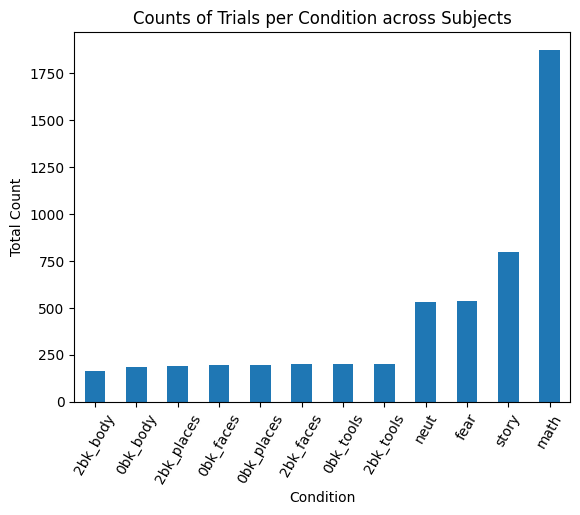

In [71]:
# Plot the trial counts
trial_count_df.drop(columns = "Total_Conditions").sum().sort_values().plot(kind = "bar")

plt.title("Counts of Trials per Condition across Subjects")

plt.ylabel("Total Count")
plt.xlabel("Condition")
plt.xticks(rotation = 60)
plt.show()

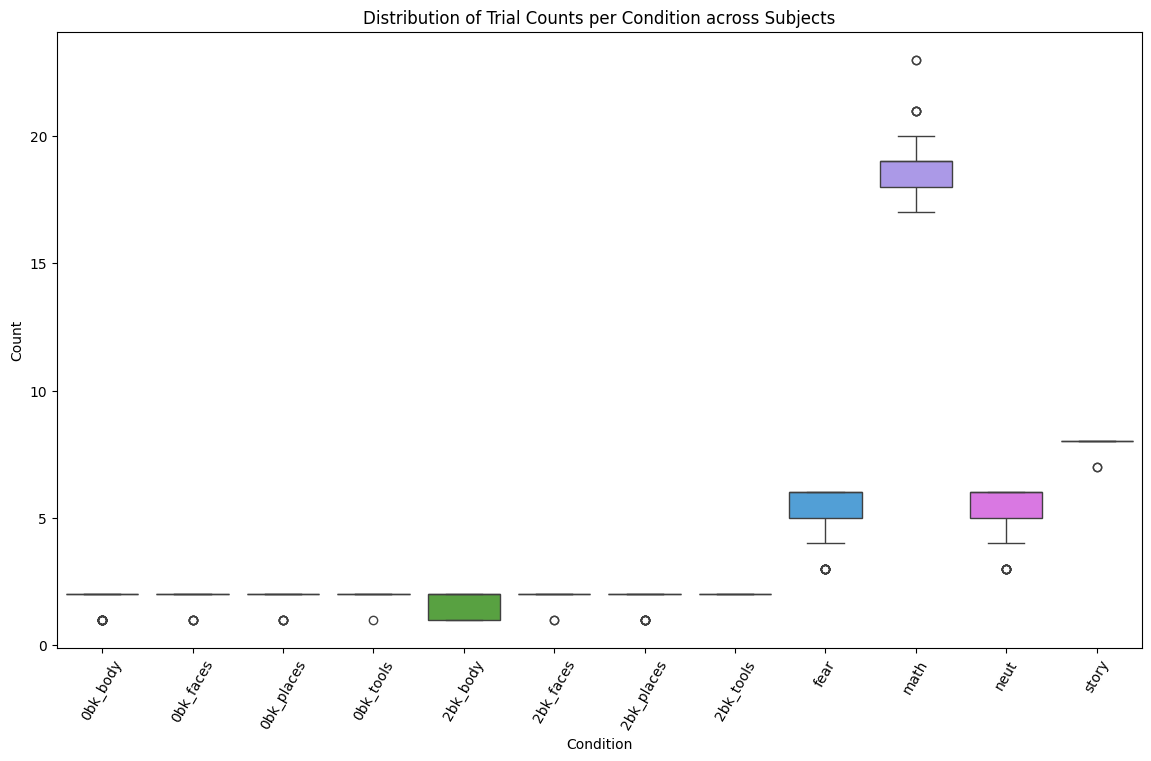

In [72]:
# Box plot of trial distribution per condition
plt.figure(figsize = (14, 8))

sns.boxplot(data = trial_count_df.drop(columns = "Total_Conditions"))

plt.title("Distribution of Trial Counts per Condition across Subjects")

plt.ylabel("Count")
plt.xlabel("Condition")
plt.xticks(rotation = 60)
plt.show()

### Standardization

#### Standardization Helper Function

In [73]:
def standardize_data(df, columns):
    """Standardizes dataframe for selected columns.
    
    Arguments:
        df (dataframe): Non-standard dataframe
        columns  (str): List of columns to be standardized
    
    Returns:
        Standardized dataframe
    """
    scaler = StandardScaler()
    
    df[columns] = scaler.fit_transform(df[columns])

    return df

#### Check Standardization and Standardize

In [74]:
parcel_columns = [col for col in averaged_df.columns if col.startswith("Parcel_")]

In [75]:
# Check standardization
mean_values_2check = averaged_df[parcel_columns].mean()
std_values_2check  = averaged_df[parcel_columns].std()

print("Means of Parcel Columns:")
print(mean_values_2check)
print("\n\nStandard Deviations of Parcel Columns:")
print(std_values_2check)

Means of Parcel Columns:
Parcel_1      7.966060
Parcel_2      0.201740
Parcel_3      0.858774
Parcel_4      6.061944
Parcel_5      5.647242
                ...   
Parcel_356   -5.682965
Parcel_357    0.551371
Parcel_358   -2.061308
Parcel_359    5.259901
Parcel_360    0.053512
Length: 360, dtype: float64


Standard Deviations of Parcel Columns:
Parcel_1      33.939223
Parcel_2      31.944751
Parcel_3      34.725444
Parcel_4      29.812809
Parcel_5      28.881377
                ...    
Parcel_356    44.463824
Parcel_357    35.372023
Parcel_358    43.477691
Parcel_359    59.964609
Parcel_360    62.258895
Length: 360, dtype: float64


In [76]:
# Standardize data
standardized_df = standardize_data(averaged_df, parcel_columns)

mean_values_2check = averaged_df[parcel_columns].mean()
std_values_2check  = averaged_df[parcel_columns].std()

print("Means of Parcel Columns:")
print(mean_values_2check)
print("\n\nStandard Deviations of Parcel Columns:")
print(std_values_2check)

Means of Parcel Columns:
Parcel_1      2.699118e-18
Parcel_2     -3.711287e-18
Parcel_3      1.417037e-17
Parcel_4     -1.214603e-17
Parcel_5     -1.349559e-17
                  ...     
Parcel_356    4.386066e-18
Parcel_357    1.349559e-18
Parcel_358    4.723456e-18
Parcel_359   -1.349559e-18
Parcel_360    2.361728e-18
Length: 360, dtype: float64


Standard Deviations of Parcel Columns:
Parcel_1      1.000095
Parcel_2      1.000095
Parcel_3      1.000095
Parcel_4      1.000095
Parcel_5      1.000095
                ...   
Parcel_356    1.000095
Parcel_357    1.000095
Parcel_358    1.000095
Parcel_359    1.000095
Parcel_360    1.000095
Length: 360, dtype: float64


### Test and Train data

#### Test/Train helper functions

In [77]:
def remove_columns(df, columns_to_remove = ["Subject", "Condition"]):
    """Removes identifier columns from dataframe for model training.

    Arguments:
        df           (dataframe): Model-ready dataframe for training
        columns_to_remove (list): list of columns to remove
    
    Returns:
        Model-ready dataframe without identifier columns.
    """
    for column in columns_to_remove:
        if column in df.columns:
            df = df.drop(columns = [column])
    return df

In [78]:
def create_train_and_test(df, label_to_drop):
    """Creates test and train data subsets using sklearn.
    Drops selected label.

    Arguments:
        df (dataframe): Dataframe of model-ready data
        label_to_drop (str): Name of column containing the label
    
    Returns:
        X and Y test and train dataframes.
    """
    X = df.drop(columns = label_to_drop)
    Y = df[label_to_drop]
    return train_test_split(X, Y, test_size = 0.2, random_state = 42)

#### Binary dataframe setup

In [79]:
WM_binary_df = standardized_df[standardized_df["Condition"].str.startswith("0bk") | standardized_df["Condition"].str.startswith("2bk")].copy()

WM_binary_df["Label"] = WM_binary_df["Condition"].apply(lambda x: 0 if "0bk" in x else 1)

#### Subtask dataframe setup

In [80]:
WM_subtask_df = standardized_df[standardized_df["Condition"].str.startswith("0bk") | standardized_df["Condition"].str.startswith("2bk")].copy()

WM_subtask_df["Label"] = WM_subtask_df["Condition"].astype("category").cat.codes

# Create table for subtask conversion
subtask_mapping  = dict(enumerate(WM_subtask_df["Condition"].astype("category").cat.categories))
conversion_table = pd.DataFrame(list(subtask_mapping.items()), columns = ["Code", "Condition"])

# Display conversion table
print(conversion_table)

   Code   Condition
0     0    0bk_body
1     1   0bk_faces
2     2  0bk_places
3     3   0bk_tools
4     4    2bk_body
5     5   2bk_faces
6     6  2bk_places
7     7   2bk_tools


In [81]:
# Remove Subject and Condition columns using the remove_columns() function
WM_binary_df  = remove_columns(WM_binary_df)
WM_subtask_df = remove_columns(WM_subtask_df)

#### Test and train split

In [82]:
# Split using the create_train_and_test() function

# Train and test split for binary model
X_WM_binary_train, X_WM_binary_test, Y_WM_binary_train, Y_WM_binary_test = create_train_and_test(WM_binary_df, "Label")

# Train and test split for subtask model
X_WM_subtask_train, X_WM_subtask_test, Y_WM_subtask_train, Y_WM_subtask_test = create_train_and_test(WM_subtask_df, "Label")

### Model Setup

#### Model setup helper functions

In [83]:
def create_MLP(input_dim,
               hidden_layers,
               activation = "relu", 
               output_activation = "sigmoid",
               dropout_rate = 0.5, l2_reg = 0.01):
    """Creates an MLP model with Dense and Dropout layers in a funnel structure.

    Arguments:
        input_dim         (int): Number of inputs
        hidden_layers    (list): List containing number of neurons in each hidden layer
        activation        (str): ???
        output_activation (str): Distribution type (?)
        dropout_rate    (float): ???
        l2_reg          (float): ???

    Returns:
        MLP model with specified parameters.
    """
    model = Sequential()

    for units in hidden_layers:
        model.add(Dense(units, 
                        input_dim = input_dim, 
                        activation = activation, 
                        kernel_regularizer = l2(l2_reg)))
        model.add(Dropout(dropout_rate))
        input_dim = None # Only set input_dim for first layer
    
    model.add(Dense(1, activation = output_activation))
    
    return model

#### Create the binary model
Number of hidden layers:
2/3 of the number of inputs (360) plus
the number of outputs (2) equal to ~241.
These neurons are arranged in the hidden layers
containing 50%, 25%, 13%, and 12% of this number.
The numbers will be rounded to whole integers.

In [84]:
# Model parameters
input_dim     = X_WM_binary_train.shape[1]
hidden_layers = [130, 66, 30, 15]

l2_reg            = 0.01
activation        = "relu"
dropout_rate      = 0.5
output_activation = "sigmoid"

In [85]:
# Model creation
binary_model = create_MLP(input_dim, hidden_layers, activation,
                          output_activation, dropout_rate, l2_reg)

binary_model.compile(optimizer = Adam(learning_rate = 0.001),
                     loss = BinaryCrossentropy(),
                     metrics = [BinaryAccuracy()])

C:\Users\User\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Taining

In [86]:
binary_model_history = binary_model.fit(X_WM_binary_train, Y_WM_binary_train,
                                        validation_split = 0.2, epochs = 50,
                                        batch_size = 32, verbose = 1)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - binary_accuracy: 0.5288 - loss: 4.1789 - val_binary_accuracy: 0.6270 - val_loss: 3.7553
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5440 - loss: 3.7742 - val_binary_accuracy: 0.6680 - val_loss: 3.4781
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5118 - loss: 3.4808 - val_binary_accuracy: 0.6762 - val_loss: 3.2093
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5832 - loss: 3.1771 - val_binary_accuracy: 0.7008 - val_loss: 2.9503
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.5606 - loss: 2.9129 - val_binary_accuracy: 0.7992 - val_loss: 2.6928
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6311 - loss: 2.6463 - val_binary_accuracy: 0.8197 - val_loss: 2.4290
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - binary_accuracy: 0.6793 - loss: 2.3869 - val_binary_accuracy: 0.8607 - val_loss: 2.1740
Epoch 8/50
31/31 ━━━

### Model Summary

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 130)                 │          46,930 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 130)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 66)                  │           8,646 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 66)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 30)                  │           2,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 30)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │             465 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 174,203 (680.48 KB)

 Trainable params: 58,067 (226.82 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 116,136 (453.66 KB)

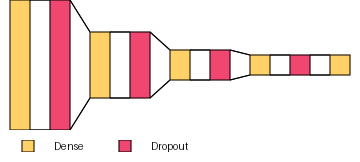

In [87]:
binary_model.summary()

# Visualize the model
visualkeras.layered_view(binary_model,
                         to_file = "BinaryMLP_structure.png",
                         spacing = 20, scale_xy = 1, 
                         scale_z = 1, max_z = 1000, 
                         legend = True, draw_volume = False,
                         one_dim_orientation = "y",
                         color_map = {
                             "Dense"  : "lightblue",
                             "Dropout": "lightyellow"
                         })

### Evaluation and Training History

In [88]:
loss, accuracy = binary_model.evaluate(X_WM_binary_test, Y_WM_binary_test, verbose = 1)

print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 946us/step - binary_accuracy: 0.8411 - loss: 0.6866
Test Loss: 0.608558714389801
Test Accuracy: 0.8852459192276001


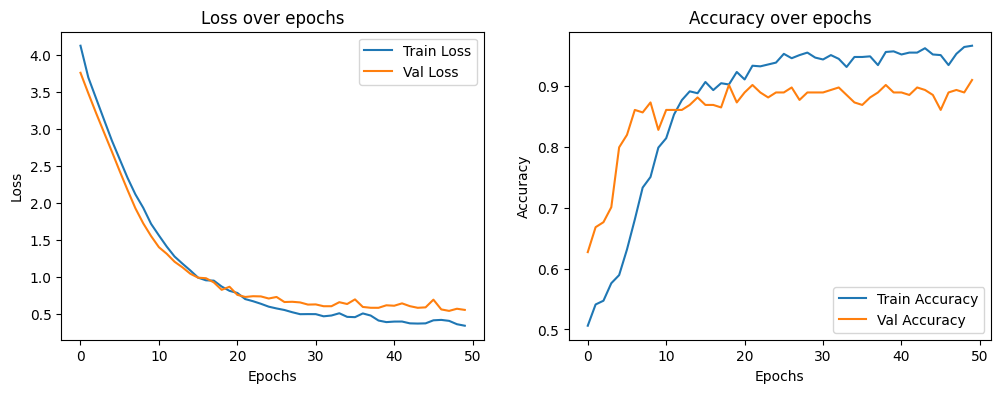

In [89]:
# Plot training history
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.plot(binary_model_history.history["loss"], label = "Train Loss")
plt.plot(binary_model_history.history["val_loss"], label = "Val Loss")
plt.title("Loss over epochs")
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(binary_model_history.history["binary_accuracy"], label = "Train Accuracy")
plt.plot(binary_model_history.history["val_binary_accuracy"], label = "Val Accuracy")
plt.title("Accuracy over epochs")
plt.ylabel("Accuracy")
plt.xlabel("Epochs")
plt.legend()

plt.show()

### Using the Model to predict Demand of Emotion and Language tasks
After our Working Memory Model was trained, we gave it the Emotion and Language task data.

#### Emotion Dataframe (+ subtasks)

In [90]:
EMOTION_df = standardized_df[standardized_df["Condition"].isin(["fear", "neut"])].copy()

EMOTION_df["Label"] = EMOTION_df["Condition"]

In [91]:
EMOTION_fear_df = standardized_df[standardized_df["Condition"] == "fear"].copy()
EMOTION_neut_df = standardized_df[standardized_df["Condition"] == "neut"].copy()

#### Language Dataframe (+ subtasks)

In [92]:
LANGUAGE_df = standardized_df[standardized_df["Condition"].isin(["story", "math"])].copy()

LANGUAGE_df["Label"] = LANGUAGE_df["Condition"]

In [93]:
LANGUAGE_math_df  = standardized_df[standardized_df["Condition"] ==  "math"].copy()
LANGUAGE_story_df = standardized_df[standardized_df["Condition"] == "story"].copy()

#### Removing Subject and Condition Columns

In [94]:
EMOTION_df      = remove_columns(EMOTION_df)
EMOTION_fear_df = remove_columns(EMOTION_fear_df)
EMOTION_neut_df = remove_columns(EMOTION_neut_df)

LANGUAGE_df       = remove_columns(LANGUAGE_df)
LANGUAGE_math_df  = remove_columns(LANGUAGE_math_df)
LANGUAGE_story_df = remove_columns(LANGUAGE_story_df)

#### Feed Emotion and Language Data for Prediction

##### Helper function for predicitons

In [95]:
def plot_model_predictions(model, prediction_subject,
                                  label, binary_state = True,
                                  non_binary_bins = 10, threshold = 0.5):
    """Feeds prediction_subjects into the model and
    visualizes each subject based on their label.

    Arguments:
        preprediction_subject (dataframe): Dataframe of the data that will be predicted by the model
        
        model                  : Model that is used for the predictions
        binary_state     (bool): Whether or not the model is generating binary predictions
        label             (str): Label of the dataframe for plotting
        non_binary_bins   (int): Set to 10 if binary_state = False
        threshthreshold (float): Set to 0.5 to put binary predictions into two bins

    Returns:
        Histogram plots of model predictions.
    """
    predictions = model.predict(prediction_subject)

    plt.figure(figsize = (5, 3))
    
    if binary_state == True:
        binary_predictions = (predictions > threshold).astype(int)
        plt.hist(binary_predictions, bins = 2, edgecolor = "k")
    else:
        plt.hist(predictions, bins = non_binary_bins, edgecolor = "k")

    plt.title(f"Histogram of Model Predictions for {label} subtask")
    plt.xlabel("Prediction Value")
    plt.ylabel("Frequency")
    plt.show

##### Plot binary predictions for Emotion and Language

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 643us/step


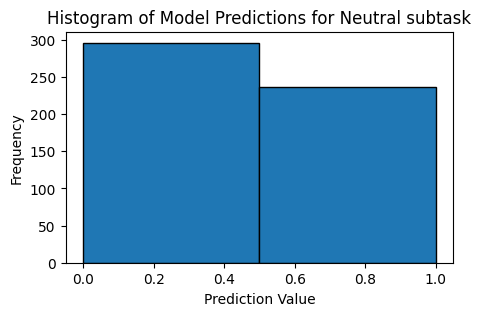

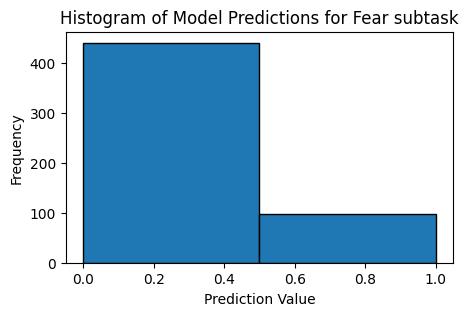

In [96]:
plot_model_predictions(binary_model, EMOTION_neut_df, "Neutral",
                       binary_state = True, threshold = 0.5)
plot_model_predictions(binary_model, EMOTION_fear_df, "Fear",
                       binary_state = True, threshold = 0.5)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step


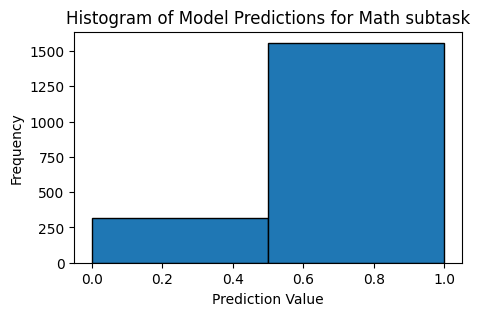

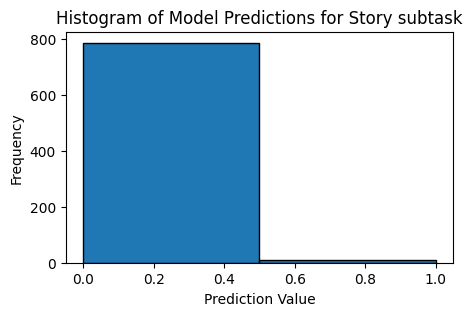

In [97]:
plot_model_predictions(binary_model, LANGUAGE_math_df, "Math",
                       binary_state = True, threshold = 0.5)
plot_model_predictions(binary_model, LANGUAGE_story_df, "Story",
                       binary_state = True, threshold = 0.5)

##### Plot categorical predictions for Emotion and Language

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


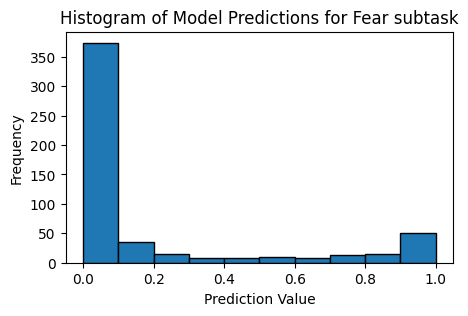

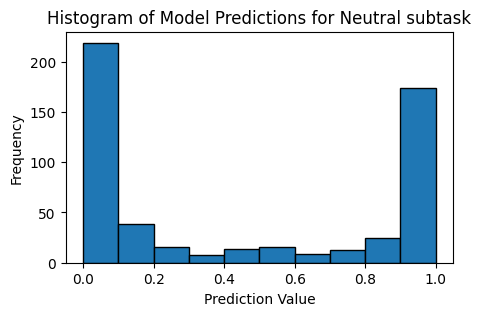

In [98]:
plot_model_predictions(binary_model, EMOTION_fear_df, "Fear",
                       binary_state = False, non_binary_bins = 10)
plot_model_predictions(binary_model, EMOTION_neut_df, "Neutral",
                       binary_state = False, non_binary_bins = 10)

59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 637us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 631us/step


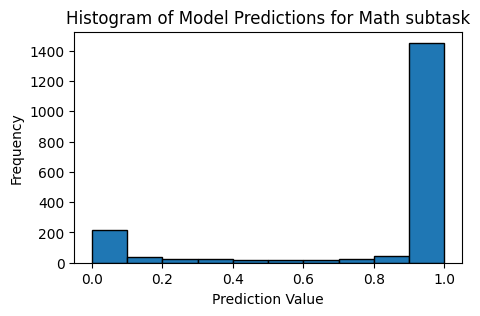

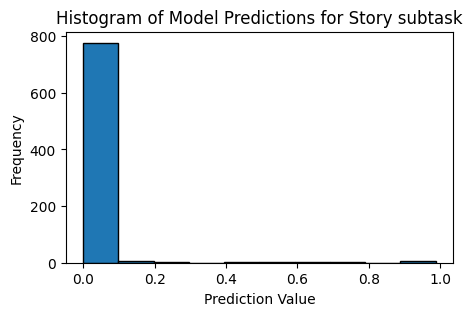

In [99]:
plot_model_predictions(binary_model, LANGUAGE_math_df, "Math",
                       binary_state = False, non_binary_bins = 10)
plot_model_predictions(binary_model, LANGUAGE_story_df, "Story",
                       binary_state = False, non_binary_bins = 10)

##### Tight subplot arrangement for easier comparison

In [100]:
list_to_predict = [EMOTION_fear_df, EMOTION_neut_df, LANGUAGE_math_df, LANGUAGE_story_df]

predictions_list = []

for item in list_to_predict:
    prediction = binary_model.predict(item)
    predictions_list.append(prediction)

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 781us/step
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 603us/step
59/59 ━━━━━━━━━━━━━━━━━━━━ 0s 573us/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 628us/step


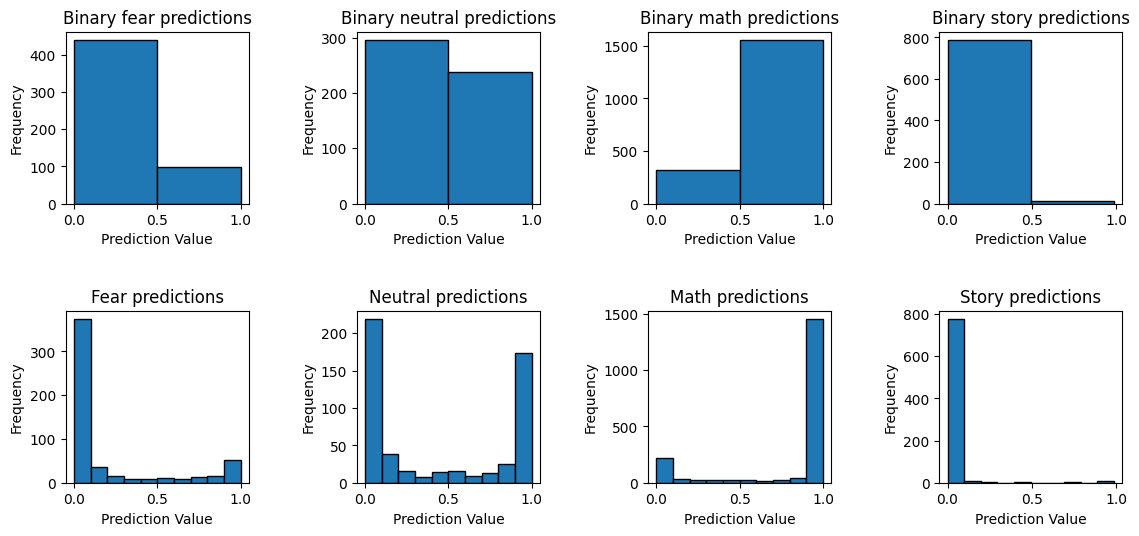

In [101]:
plt.figure(figsize = (12, 6))

# Binary emotion plots
plt.subplot(2, 4, 1)
plt.hist(predictions_list[0], bins = 2, edgecolor = "k")
plt.title("Binary fear predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")

plt.subplot(2, 4, 2)
plt.hist(predictions_list[1], bins = 2, edgecolor = "k")
plt.title("Binary neutral predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")

# Binary language plots
plt.subplot(2, 4, 3)
plt.hist(predictions_list[2], bins = 2, edgecolor = "k")
plt.title("Binary math predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")

plt.subplot(2, 4, 4)
plt.hist(predictions_list[3], bins = 2, edgecolor = "k")
plt.title("Binary story predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")


# Non-binary emotion plots
plt.subplot(2, 4, 5)
plt.hist(predictions_list[0], bins = 10, edgecolor = "k")
plt.title("Fear predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")

plt.subplot(2, 4, 6)
plt.hist(predictions_list[1], bins = 10, edgecolor = "k")
plt.title("Neutral predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")

# Non_binary language plots
plt.subplot(2, 4, 7)
plt.hist(predictions_list[2], bins = 10, edgecolor = "k")
plt.title("Math predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")

plt.subplot(2, 4, 8)
plt.hist(predictions_list[3], bins = 10, edgecolor = "k")
plt.title("Story predictions")
plt.xlabel("Prediction Value")
plt.ylabel("Frequency")

plt.tight_layout(pad = 3.0)
plt.show()